In [60]:
import os
import json
from typing import Dict, List, Tuple, Any, Union

import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import anndata
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm
import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')

In [2]:
DATA_DIR = os.path.join('..', 'output', 'preprocess')
GRN_DIR = os.path.join('..', 'output', 'benchmark', 'grn_models')
BASELINE_GRN_DIR = os.path.join('..', 'output', 'benchmark', 'baseline_models')
RESULTS_DIR = os.path.join('..', 'output', 'benchmark', 'second-validation')
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
adata_rna = anndata.read_h5ad(os.path.join(DATA_DIR, 'bulk_adata_integrated.h5ad'))

In [4]:
adata_rna.layers

Layers with keys: counts, lognorm, n_counts, pearson, scgen_lognorm, scgen_pearson, seurat_lognorm, seurat_pearson

In [5]:
groups = LabelEncoder().fit_transform(adata_rna.obs.plate_name)
set(groups)

{0, 1, 2, 3, 4, 5}

In [6]:
try:
    gene_names = adata_rna.var.gene.to_numpy()
except:
    gene_names = adata_rna.var.index.to_numpy()
gene_names

array(['A1BG', 'A1BG-AS1', 'A2M', ..., 'ZYG11B', 'ZYX', 'ZZEF1'],
      dtype=object)

In [7]:
norm_t = 'lognorm'
X = adata_rna.layers[f'{norm_t}']
X.shape

(2170, 15215)

In [8]:
n_genes = X.shape[1]

In [9]:
X = RobustScaler().fit_transform(X)

In [10]:
def load_grn(filepath: str, gene_names: np.ndarray, eps: float = 1e-10) -> np.ndarray:
    gene_dict = {gene_name: i for i, gene_name in enumerate(gene_names)}
    A = np.zeros((len(gene_names), len(gene_names)), dtype=float)
    df = pd.read_csv(filepath, sep=',', header='infer', index_col=0)
    for source, target, weight in zip(df['source'], df['target'], df['weight']):
        if (source not in gene_dict) or (target not in gene_dict):
            continue
        i = gene_dict[source]
        j = gene_dict[target]
        A[i, j] = float(weight)
    print(f'Sparsity: {np.mean(A == 0)}')
    return A

In [11]:
METHODS = ['collectri', 'ananse', 'celloracle', 'figr', 'granie', 'scenicplus', 'scglue', 'positive-control', 'negative-control']

In [12]:
grns = []
for method in METHODS:
    if method == 'positive-control':
        grn = load_grn(os.path.join(BASELINE_GRN_DIR, 'positive_control.csv'), gene_names)
    elif method == 'negative-control':
        grn = 2 * (np.random.rand(n_genes, n_genes) - 0.5)
    else:
        grn = load_grn(os.path.join(GRN_DIR, f'{method}.csv'), gene_names)
    grns.append(grn)

Sparsity: 0.9999170526430831
Sparsity: 0.9997871585162997
Sparsity: 0.9993575489189942
Sparsity: 0.999921540837221
Sparsity: 0.9999646300927801
Sparsity: 0.9998662526786344
Sparsity: 0.9998312499480283
Sparsity: 0.9991360550263833


In [13]:
def fill_zeros_in_grn(A: np.ndarray, eps: float = 1e-10):
    A = np.copy(A)
    A[A > 0] = A[A > 0] + eps
    A[A < 0] = A[A < 0] - eps
    A[A == 0] = np.random.rand(*A[A == 0].shape) * 2 * eps - eps
    return A


def consensus_number_of_regulators(reduction_t: Union[str, float], *grns: np.ndarray) -> np.ndarray:
    M = np.asarray(list(grns))
    if isinstance(reduction_t, float):
        return np.ceil(np.quantile(np.sum(M != 0, axis=1), reduction_t, axis=0)).astype(int)
    if reduction_t == 'median':
        return np.ceil(np.median(np.sum(M != 0, axis=1), axis=0)).astype(int)
    elif reduction_t == 'mean':
        return np.ceil(np.mean(np.sum(M != 0, axis=1), axis=0)).astype(int)
    elif reduction_t == 'min':
        return np.ceil(np.min(np.sum(M != 0, axis=1), axis=0)).astype(int)
    elif reduction_t == 'max':
        return np.ceil(np.max(np.sum(M != 0, axis=1), axis=0)).astype(int)
    else:
        raise NotImplementedError(f'Unknown reduction "{reduction_t}"')

In [14]:
reduction_t = 'median'
n_features = consensus_number_of_regulators(reduction_t, *grns[:-2])
n_features_min = consensus_number_of_regulators('min', *grns[:-2])
n_features_max = consensus_number_of_regulators('max', *grns[:-2])

In [15]:
n_features.max()

21

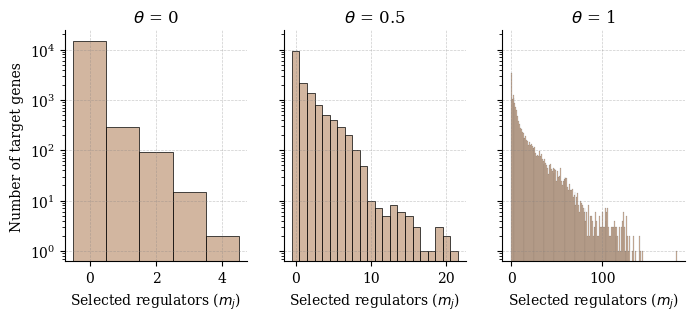

In [77]:
fig, axes = plt.subplots(1,3, figsize=(8, 3), sharey=True)

ax = axes[0]
seaborn.histplot(data=n_features_min, ax=ax, discrete=True, color='#C49E81',  linewidth=.5)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
ax.set_xlabel(r'Selected regulators ($m_{j}$)')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 0')

ax = axes[1]
seaborn.histplot(data=n_features, ax=ax, discrete=True, color='#C49E81', linewidth=.5)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
ax.set_xlabel(r'Number of regulators')
ax.set_xlabel(r'Selected regulators ($m_{j}$)')
ax.set_title(r'$\theta$ = 0.5')

ax = axes[2]
seaborn.histplot(n_features_max, ax=ax, discrete=True, color='#C49E81')
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
ax.set_xlabel(r'Number of regulators')
ax.set_xlabel(r'Selected regulators ($m_{j}$)')
ax.set_title(r'$\theta$ = 1')

plt.savefig('../output/benchmark/figs/theta.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [17]:
def cross_validate_gene(estimator_t: str, X: np.ndarray, groups: np.ndarray, grn: np.ndarray, j: int, n_features: int = 10) -> Dict[str, float]:
    
    results = {'r2': 0, 'mse': 0}
    
    if n_features == 0:
        return results
    
    # Feature selection
    scores = np.abs(grn[:, j])
    scores[j] = 0
    selected_features = np.argsort(scores)[-n_features:]

    y_pred, y_target, r2s = [], [], []
    for t, (train_index, test_index) in enumerate(LeaveOneGroupOut().split(X, X[:, 0], groups)):

        if estimator_t == 'ridge':
            model = Ridge()
        elif estimator_t == 'lasso':
            model = Lasso()
        elif estimator_t == 'linear':
            model = LinearRegression()
        elif estimator_t == 'svm':
            model = LinearSVR(dual='auto', max_iter=10000)
        elif estimator_t == 'gbm':
            model = lightgbm.LGBMRegressor(verbosity=-1, n_jobs=4)
        elif estimator_t == 'rf':
            model = RandomForestRegressor()
        elif estimator_t == 'adaboost':
            model = AdaBoostRegressor()
        elif estimator_t == 'knn':
            model = KNeighborsRegressor()
        elif estimator_t == 'mlp':
            model = MLPRegressor(hidden_layer_sizes=(16,))
        else:
            raise NotImplementedError(f'Unknown model "{estimator_t}"')

        X_ = X[:, selected_features]
        y_ = X[:, j]
        X_train = X_[train_index, :]
        X_test = X_[test_index, :]
        y_train = y_[train_index]
        y_test = y_[test_index]
        
        model.fit(X_train, y_train)

        y_pred.append(model.predict(X_test))
        y_target.append(y_test)
        r2s.append(r2_score(y_target[-1], y_pred[-1]))

    y_pred = np.concatenate(y_pred, axis=0)
    y_target = np.concatenate(y_target, axis=0)
    
    results['r2'] = float(r2_score(y_target, y_pred))
    results['avg-r2'] = float(np.mean(r2s))
    results['mse'] = float(mean_squared_error(y_target, y_pred))
    
    return results


def cross_validate(estimator_t: str, gene_names: np.ndarray, X: np.ndarray, groups: np.ndarray, grn: np.ndarray, n_features: np.ndarray) -> List[Dict[str, float]]:
    n_genes = len(grn)
    
    grn = fill_zeros_in_grn(grn)
    
    results = []
    
    for j in tqdm.tqdm(range(n_genes)):
        
        res = cross_validate_gene(estimator_t, X, groups, grn, j, n_features=int(n_features[j]))
        results.append(res)
    
    return {
        'gene_names': list(gene_names),
        'scores': results
    }

In [18]:
aaaa

NameError: name 'aaaa' is not defined

In [ ]:
estimator_t = 'svm'
override = False

for reduction_t in ['median']:
    folder = os.path.join(RESULTS_DIR, norm_t, estimator_t, reduction_t if isinstance(reduction_t, str) else str(int(100 * reduction_t)))
    os.makedirs(folder, exist_ok=True)
    for i, method in enumerate(METHODS):
        if (not override) and os.path.exists(os.path.join(folder, f'{method}.results.json')):
            continue
        print(method, reduction_t, norm_t)
        grn = grns[i]
        results = cross_validate(estimator_t, gene_names, X, groups, grn, n_features)
        with open(os.path.join(folder, f'{method}.results.json'), 'w') as f:
            json.dump(results, f)

positive-control median SL


100%|████████████████████████████████████████████████████████████████████████████| 15215/15215 [02:43<00:00, 93.12it/s]


negative-control median SL


100%|████████████████████████████████████████████████████████████████████████████| 15215/15215 [02:37<00:00, 96.82it/s]


In [19]:
surrogate_names = {
    'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
    'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
    'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
    'FigR': 'FigR', 'figr':'FigR', 'figr_sign':'FigR-signs',
    'baseline':'Baseline',
    'cov_net': 'Pearson cov',
    'GRANIE': 'GRANIE', 'granie':'GRANIE',
    'ANANSE': 'ANANSE', 'ananse':'ANANSE',
    'scGLUE': 'scGLUE', 'scglue':'scGLUE',
    'HKG': 'HKG', 'HKGs':'HKG',
    'positive-control': 'Positive Control', 'positive_control': 'Positive Control',
    'negative-control': 'Negative Control', 'negative_control':'Negative Control',
    'pearson':'Pearson',
    'SL':'SLA'
}

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRANIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRANIE': '-',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': ':',
    'Positive Control': '-',
    'Negative Control': '-'
}

MARKERS = {
    'Random': '.',
    'CollectRI': '.',
    'FigR': 'o',
    'CellOracle': 'd',
    'GRANIE': 'v',
    'ANANSE': 's',
    'scGLUE': 'x',
    'Scenic+': '*',
    'Positive Control': '.',
    'Negative Control': '.'
}

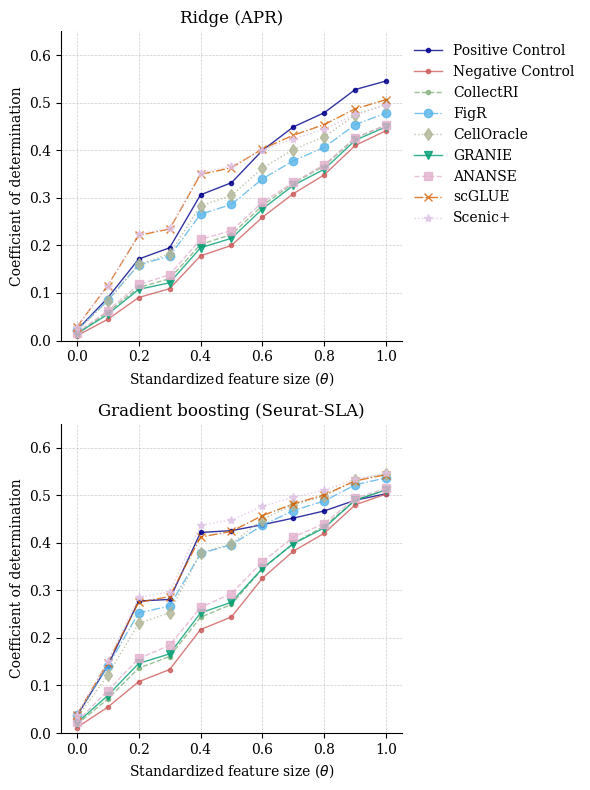

In [85]:
SORTED_METHODS = ['positive-control', 'negative-control', 'collectRI', 'FigR', 'CellOracle', 'GRANIE', 'ANANSE', 'scGLUE', 'scenicplus']

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharey=False)

for k, (norm2_t, estimator_t) in enumerate(zip(['pearson', 'seurat_lognorm'], ['ridge', 'gbm'])):
    ax = axes[k]
    ax.grid(alpha=0.4, linewidth=.5, color='grey', linestyle='--')
    # xs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    xs = np.arange(0, 1.1, .1)

    for method in SORTED_METHODS:

        series = []

        for reduction_t in ['min', '10', '20', '30', '40', 'median', '60', '70', '80', '90', 'max']:
            with open(os.path.join(RESULTS_DIR, norm2_t, estimator_t, reduction_t, f'{method}.results.json'), 'r') as f:
                results = json.load(f)
            
            r2 = []
            for i in range(len(results['scores'])):
                if n_features[i] != 0:
                    r2.append(results['scores'][i]['r2'])

            series.append(float(np.mean(r2)))
        
        ax.plot(
            xs, series, label=surrogate_names[method], color=COLORS[surrogate_names[method]],
            linestyle=LINESTYLES[surrogate_names[method]], marker=MARKERS[surrogate_names[method]], alpha=.8, linewidth=1,
        )

    ax.set_xticks(xs)

    if k == 0:
        ax.set_title('Ridge (APR)')
        ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
        
    elif k == 1:
        ax.set_title('Gradient boosting (Seurat-SLA)')
        
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_ylabel('Coefficient of determination')
    ax.set_xlabel(r'Standardized feature size ($\theta$)')
    
    ax.set_ylim([0, 0.65])
    ax.set_xticks(np.arange(0, 1.1, .2))
plt.tight_layout()
plt.savefig('../output/benchmark/figs/second-validation-performance-theta.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [29]:
reduction_t = 'median'
estimator_t = 'gbm'

SORTED_METHODS = ['negative-control', 'collectRI', 'GRANIE', 'ANANSE', 'CellOracle', 'FigR', 'scGLUE', 'scenicplus', 'positive-control']

palette = {method: COLORS[surrogate_names[method]] for method in SORTED_METHODS}
palette.update(COLORS)

xs, ys, zs, hue = [], [], [], []
mat = []
all_results = []
for norm2_t in ['seurat_pearson']:
    
    row = []
    
    for method in SORTED_METHODS:
        with open(os.path.join(RESULTS_DIR, norm2_t, estimator_t, reduction_t, f'{method}.results.json'), 'r') as f:
            results = json.load(f)
        all_results.append(results)
        r2 = []
        for i in range(len(results['scores'])):
            if n_features[i] != 0:
                r2.append(results['scores'][i]['r2'])
        #print(method, norm2_t, np.median(r2))
        for value in r2:
            xs.append(surrogate_names[method])
            ys.append(value)
            zs.append(norm2_t)
        
        row.append(float(np.mean(r2)))
    mat.append(row)
    j = np.argmax(row[:-2])
    print(estimator_t + ' & ' + norm2_t + ' & ' + ' & '.join(['\\textbf{' + f'{x:.3f}' + '}' if (i == j) else f'{x:.3f}' for i, x in enumerate(row)]))


gbm & seurat_pearson & 0.265 & 0.288 & 0.270 & 0.297 & 0.426 & 0.398 & \textbf{0.427} & 0.452 & 0.470


/tmp/ipykernel_1271/1212966498.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.violinplot(ax=ax, x=xs, y=ys, palette=palette, inner='box', width=.7, linewidth=.1)


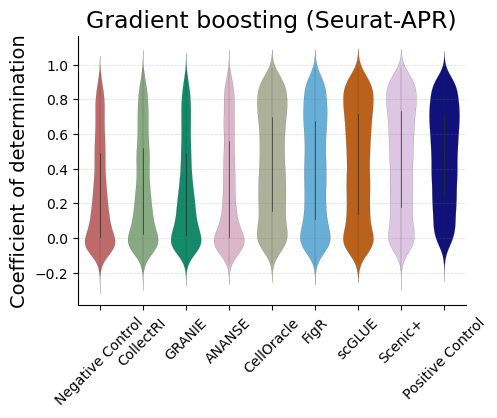

negative-control TtestResult(statistic=nan, pvalue=nan, df=5895)
collectRI TtestResult(statistic=8.332096942659723, pvalue=4.8923650365777703e-17, df=5895)
GRANIE TtestResult(statistic=1.681441448690292, pvalue=0.04636508526053314, df=5895)
ANANSE TtestResult(statistic=11.540396551194467, pvalue=8.756501433933453e-31, df=5895)
CellOracle TtestResult(statistic=59.94647621489763, pvalue=0.0, df=5895)
FigR TtestResult(statistic=43.98685091962139, pvalue=0.0, df=5895)
scGLUE TtestResult(statistic=54.12632293160113, pvalue=0.0, df=5895)
scenicplus TtestResult(statistic=66.8350215590333, pvalue=0.0, df=5895)
positive-control TtestResult(statistic=74.06600032319727, pvalue=0.0, df=5895)


In [31]:
plt.figure(figsize=(5, 3.5))
ax = plt.subplot(1, 1, 1)
ax.grid(alpha=0.3, linewidth=.5, color='grey', linestyle='--')

mat = np.asarray(mat)
seaborn.violinplot(ax=ax, x=xs, y=ys, palette=palette, inner='box', width=.7, linewidth=.1)

# for ii, x_pos in enumerate(x_positions):
#     y_pos = y_positions[ii] + std[ii] + .3 * i_plot
#     txt = f'{mean_score_list[ii]:.2f}'
#     ax.text(x_pos, y_pos, txt, ha='center', color='black', fontsize=8)

        
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
plt.xticks(fontsize=10)
ax.set_ylabel('Coefficient of determination', fontsize=14)
ax.set_title('Gradient boosting (Seurat-APR)', fontsize=17)
plt.xticks(rotation=45)
plt.savefig('../output/benchmark/figs/second-validation-r2-dist.png', dpi=300, transparent=True)
plt.show()

for method, res in zip(SORTED_METHODS, all_results):
    x1 = np.asarray([res['scores'][i]['r2'] for i in range(len(res['scores'])) if n_features[i] > 0])
    x2 = np.asarray([all_results[0]['scores'][i]['r2'] for i in range(len(all_results[0]['scores'])) if n_features[i] > 0])
    print(method, scipy.stats.ttest_rel(x1, x2, alternative='greater'))

gbm & pearson & 0.221 & 0.247 & 0.237 & 0.259 & 0.369 & 0.352 & \textbf{0.390} & 0.413 & 0.356
gbm & SL & \textbf{0.325} & 0.199 & 0.210 & 0.217 & 0.325 & 0.311 & 0.203 & 0.359 & 0.217
gbm & seurat_pearson & 0.265 & 0.288 & 0.270 & 0.297 & 0.426 & 0.398 & \textbf{0.427} & 0.452 & 0.470
gbm & seurat_lognorm & 0.244 & 0.270 & 0.275 & 0.293 & 0.398 & 0.396 & \textbf{0.424} & 0.448 & 0.425
gbm & scgen_pearson & 0.673 & 0.679 & 0.677 & 0.677 & 0.720 & 0.731 & \textbf{0.744} & 0.755 & 0.718
gbm & scgen_lognorm & 0.634 & 0.636 & 0.648 & 0.647 & 0.680 & 0.705 & \textbf{0.721} & 0.731 & 0.673


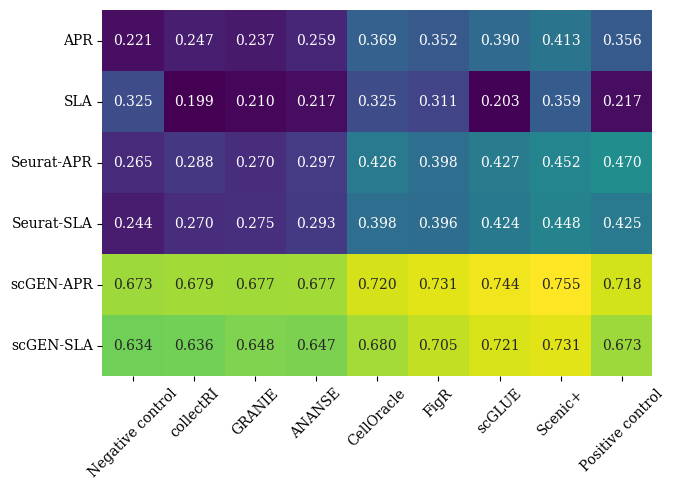

In [82]:
reduction_t = 'median'
estimator_t = 'gbm'

SORTED_METHODS = ['negative-control', 'collectRI', 'GRANIE', 'ANANSE', 'CellOracle', 'FigR', 'scGLUE', 'scenicplus', 'positive-control']

mat = []
for norm2_t in ['pearson', 'SL', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']:
    
    row = []
    
    for method in SORTED_METHODS:
        with open(os.path.join(RESULTS_DIR, norm2_t, estimator_t, reduction_t, f'{method}.results.json'), 'r') as f:
            results = json.load(f)
        r2 = []
        for i in range(len(results['scores'])):
            if n_features[i] != 0:
                r2.append(results['scores'][i]['r2'])
        r2 = np.asarray(r2)
        
        row.append(float(np.average(r2)))
    mat.append(row)
    j = np.argmax(row[:-2])
    print(estimator_t + ' & ' + norm2_t + ' & ' + ' & '.join(['\\textbf{' + f'{x:.3f}' + '}' if (i == j) else f'{x:.3f}' for i, x in enumerate(row)]))
mat = np.asarray(mat)

plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
xticklabels = ['Negative control', 'collectRI', 'GRANIE', 'ANANSE', 'CellOracle', 'FigR', 'scGLUE', 'Scenic+', 'Positive control']
yticklabels = ['APR', 'SLA', 'Seurat-APR', 'Seurat-SLA', 'scGEN-APR', 'scGEN-SLA']
seaborn.heatmap(mat, ax=ax, square=True, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='.3f', cmap='viridis')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../output/benchmark/figs/second-validation-heatmap.png', dpi=300, transparent=True)

In [33]:
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = set(df.loc[:, 0].to_numpy())

In [34]:
with open(os.path.join(RESULTS_DIR, 'pearson', 'ridge', 'median', 'scenicplus.results.json'), 'r') as f:
    results = json.load(f)
r2 = []
for i in range(len(results['scores'])):
    if n_features[i] != 0:
        r2.append(results['scores'][i]['r2'])
    else:
        r2.append(np.nan)
r2 = np.asarray(r2, dtype=float)
r2
is_hkg = np.asarray([gene_name in housekeeping_genes for gene_name in gene_names], dtype=bool)
np.nanmean(r2[is_hkg] < 0), np.nanmean(r2[~is_hkg] < 0)

(0.04981497295758611, 0.029738506238249873)

/root/anaconda3/envs/py10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6862: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

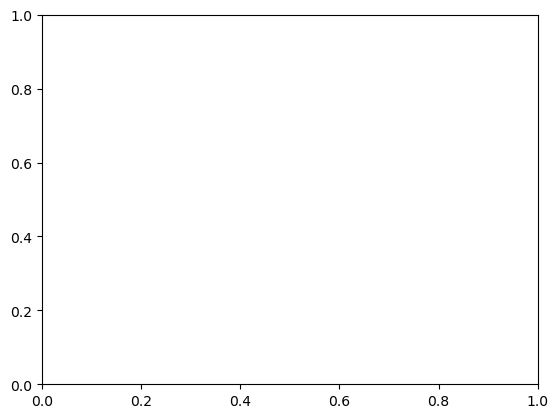

In [35]:
plt.hist(r2[is_hkg] < 0, alpha=0.4)
plt.hist(r2[~is_hkg] < 0, alpha=0.4)
plt.show()